<a href="https://colab.research.google.com/github/alawrence30/Deep-Learning/blob/main/9_10_Assignment_4_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#https://www.kaggle.com/code/tilasousa/face-mask-detection-using-keras-cnn

# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import cv2
from scipy.spatial import distance
import glob
from warnings import filterwarnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import classification_report , confusion_matrix
from skimage import io
filterwarnings("ignore")

from keras_preprocessing.image import img_to_array
from keras_preprocessing.image import load_img


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow_datasets as tfds
from keras import callbacks
from sklearn.metrics import accuracy_score
from os import listdir
from os.path import isfile, join

In [3]:
## Accuracy and Loss Graph
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

## Validation Report
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

## Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

# defining callback function to avoid overfit
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 6, 
                                        restore_best_weights = True, verbose=1)

# EDA

The path is created for getting data and then I concatened dataframes of mask and without mask.

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
path  = '/content/gdrive/My Drive/MSDS 458/Assignment 4 - Final/Data/Face Mask Dataset/'

In [7]:
# train dataset
train_dir = os.path.join(path, 'Train')

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            batch_size=32,
                                                            image_size=(256,256),
                                                            shuffle=True)

Found 10000 files belonging to 2 classes.


In [8]:
# validation dataset
validation_dir = os.path.join(path, 'Validation')

validation_ds = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                            batch_size=32,
                                                            image_size=(256,256),
                                                            shuffle=True)

Found 800 files belonging to 2 classes.


In [9]:
# test dataset
test_dir = os.path.join(path, 'Test')

test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            batch_size=32,
                                                            image_size=(256,256),
                                                            shuffle=True)

Found 992 files belonging to 2 classes.


In [10]:
class_names = train_ds.class_names
print(class_names)

['WithMask', 'WithoutMask']


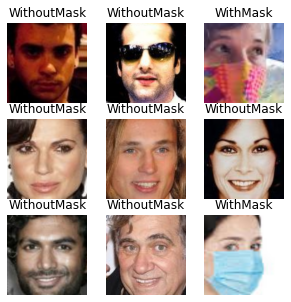

In [11]:
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
# autotune buffer to avoid I/0 block
autotune = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=autotune)
validation_ds = validation_ds.cache().prefetch(buffer_size=autotune)

# Model 9

CNN

Input layer

Convolutional layer 1: 32 units, Relu activation - Maxpool Layer 128x128

Convolutional layer 2: 64 units, Relu activation - Maxpool Layer 64x64

Convolutional layer 3: 128 units Relu activation - Maxpool Layer 32x32

Convolutional layer 4: 256 units, Relu activation - Maxpool Layer 16x16

Hidden Layer 1: 256 units, Relu Activation

Output layer: Dense 2 units, sigmoid activation


In [13]:
num_classes = 2

model9 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
  tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
  tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

model9.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [14]:
history9 = model9.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=41,
  callbacks =[earlystopping]
)

Epoch 1/41
313/313 [==============================] - 504s 2s/step - loss: 0.1883 - accuracy: 0.9353 - val_loss: 0.0616 - val_accuracy: 0.9837
Epoch 2/41
313/313 [==============================] - 25s 81ms/step - loss: 0.0557 - accuracy: 0.9796 - val_loss: 0.0535 - val_accuracy: 0.9875
Epoch 3/41
313/313 [==============================] - 26s 82ms/step - loss: 0.0474 - accuracy: 0.9842 - val_loss: 0.0301 - val_accuracy: 0.9925
Epoch 4/41
313/313 [==============================] - 25s 81ms/step - loss: 0.0330 - accuracy: 0.9887 - val_loss: 0.0144 - val_accuracy: 0.9912
Epoch 5/41
313/313 [==============================] - 25s 80ms/step - loss: 0.0296 - accuracy: 0.9899 - val_loss: 0.0167 - val_accuracy: 0.9937
Epoch 6/41
313/313 [==============================] - 25s 81ms/step - loss: 0.0215 - accuracy: 0.9925 - val_loss: 0.0216 - val_accuracy: 0.9912
Epoch 7/41
313/313 [==============================] - 25s 81ms/step - loss: 0.0162 - accuracy: 0.9934 - val_loss: 0.0352 - val_accuracy: 

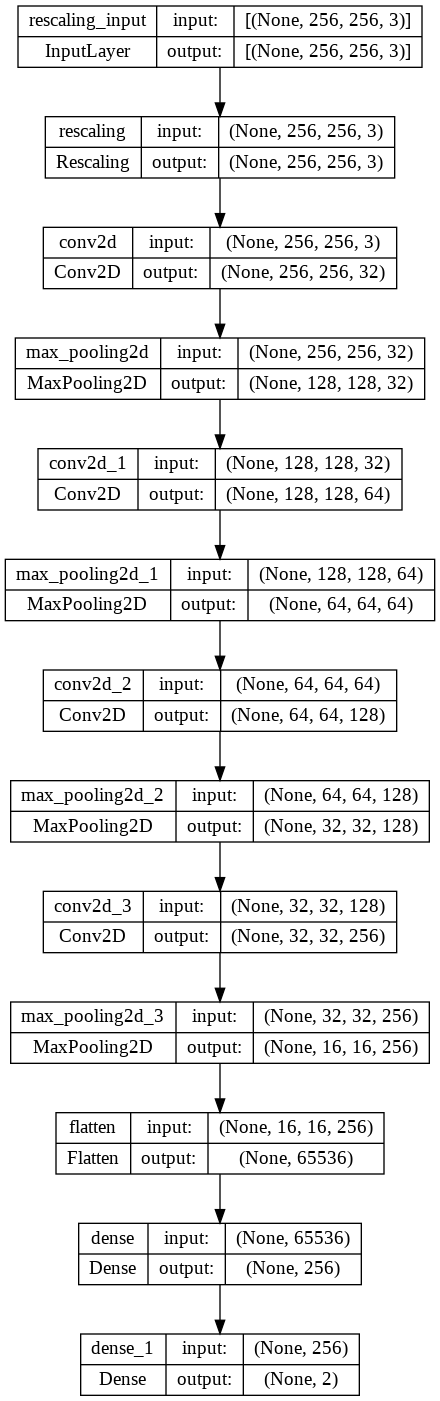

In [15]:
keras.utils.plot_model(model9, "model9.png", show_shapes=True) 

## Evaluate

In [16]:
history_dict9 = history9.history
history_dict9.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [17]:
history_df9=pd.DataFrame(history_dict9)
history_df9.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
5,0.022,0.993,0.022,0.991
6,0.016,0.993,0.035,0.983
7,0.011,0.997,0.030,0.991
8,0.025,0.992,0.030,0.989
9,0.014,0.996,0.031,0.991


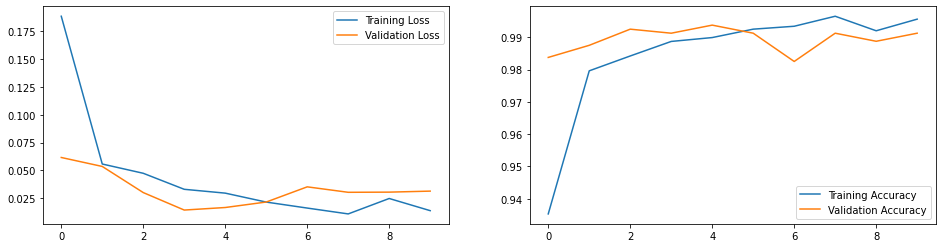

In [18]:
## Loss and acuracy
plot_history(history9)

In [19]:
test_pred9 = model9.predict(test_ds)
test_pred9 = np.argmax(test_pred9,axis = 1)
test_labels9 = np.concatenate([y for x, y in test_ds], axis=0)

31/31 [==============================] - 61s 1s/step


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

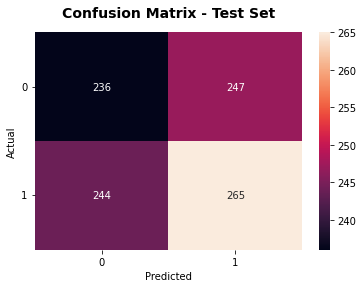

In [20]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels9,
    test_pred9,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 10)
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 10) 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 14,weight = 'bold',pad=15)

In [21]:
# 0 = without mask, 1 = with mask
# 992 images in test set, model missed 251 with mask and 249 without mask

In [35]:
import numpy
from sklearn import metrics

actual9 = test_labels9
predicted9 = test_pred9

Accuracy = metrics.accuracy_score(actual9, predicted9)
Precision = metrics.precision_score(actual9, predicted9)
Sensitivity_recall = metrics.recall_score(actual9, predicted9)
Specificity = metrics.recall_score(actual9, predicted9, pos_label=0)
F1_score = metrics.f1_score(actual9, predicted9)

#metrics:
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})

{'Accuracy': 0.5050403225806451, 'Precision': 0.517578125, 'Sensitivity_recall': 0.5206286836935167, 'Specificity': 0.4886128364389234, 'F1_score': 0.5190989226248776}


# Model 10

CNN

Input layer

Convolutional layer 3: 128 units Relu activation 

Maxpool Layer 32x32

Convolutional layer 4: 256 units, Relu activation 

Maxpool Layer 16x16

Hidden Layer 1: 256 units, Relu Activation

Output layer: Dense 2 units, sigmoid activation


In [22]:
num_classes = 2

model10 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
  tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

model10.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [23]:
history10 = model10.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=41,
  callbacks =[earlystopping]
)

Epoch 1/41
313/313 [==============================] - 99s 309ms/step - loss: 0.7355 - accuracy: 0.9194 - val_loss: 0.0614 - val_accuracy: 0.9800
Epoch 2/41
313/313 [==============================] - 93s 298ms/step - loss: 0.0823 - accuracy: 0.9734 - val_loss: 0.0690 - val_accuracy: 0.9800
Epoch 3/41
313/313 [==============================] - 93s 297ms/step - loss: 0.0563 - accuracy: 0.9808 - val_loss: 0.0688 - val_accuracy: 0.9775
Epoch 4/41
313/313 [==============================] - 93s 298ms/step - loss: 0.0411 - accuracy: 0.9858 - val_loss: 0.0340 - val_accuracy: 0.9887
Epoch 5/41
313/313 [==============================] - 93s 298ms/step - loss: 0.0336 - accuracy: 0.9876 - val_loss: 0.0273 - val_accuracy: 0.9912
Epoch 6/41
313/313 [==============================] - 93s 296ms/step - loss: 0.0311 - accuracy: 0.9888 - val_loss: 0.0320 - val_accuracy: 0.9875
Epoch 7/41
313/313 [==============================] - 93s 297ms/step - loss: 0.0374 - accuracy: 0.9871 - val_loss: 0.0249 - val_ac

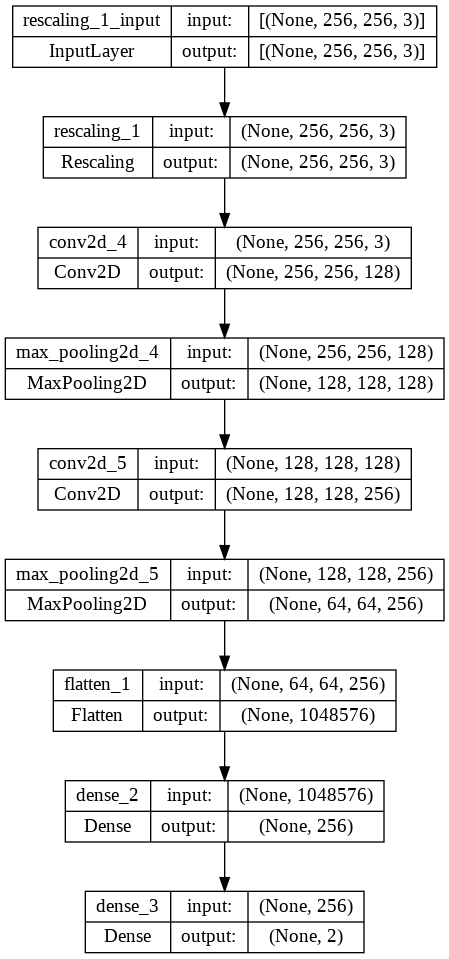

In [24]:
keras.utils.plot_model(model10, "model10.png", show_shapes=True) 

## Evaluate

In [25]:
history_dict10 = history10.history
history_dict10.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
history_df10=pd.DataFrame(history_dict10)
history_df10.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
8,0.030,0.989,0.055,0.976
9,0.016,0.994,0.048,0.993
10,0.017,0.995,0.037,0.991
11,0.025,0.992,0.045,0.988
12,0.019,0.993,0.048,0.989


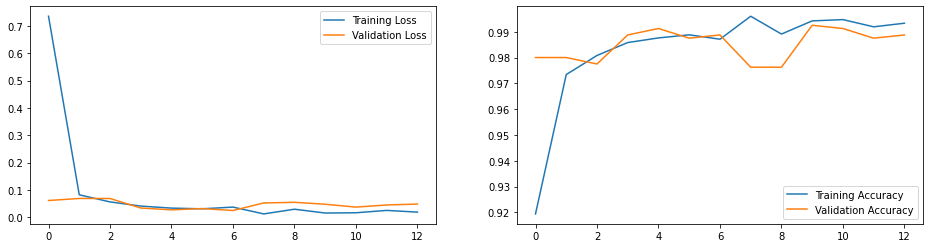

In [27]:
## Loss and acuracy
plot_history(history10)

In [28]:
test_pred10 = model10.predict(test_ds)
test_pred10 = np.argmax(test_pred10,axis = 1)
test_labels10 = np.concatenate([y for x, y in test_ds], axis=0)

31/31 [==============================] - 3s 100ms/step


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

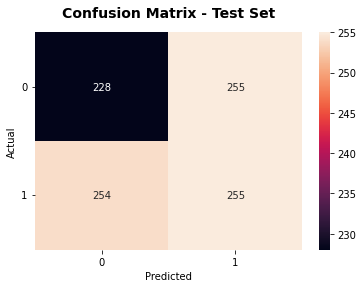

In [29]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels10,
    test_pred10,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 10)
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 10) 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 14,weight = 'bold',pad=15)

In [30]:
# 0 = without mask, 1 = with mask
# 992 images in test set, model missed 251 with mask and 249 without mask

In [34]:
actual10 = test_labels10
predicted10 = test_pred10

Accuracy = metrics.accuracy_score(actual10, predicted10)
Precision = metrics.precision_score(actual10, predicted10)
Sensitivity_recall = metrics.recall_score(actual10, predicted10)
Specificity = metrics.recall_score(actual10, predicted10, pos_label=0)
F1_score = metrics.f1_score(actual10, predicted10)

#metrics:
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})

{'Accuracy': 0.48689516129032256, 'Precision': 0.5, 'Sensitivity_recall': 0.5009823182711198, 'Specificity': 0.4720496894409938, 'F1_score': 0.5004906771344456}
